In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [24]:
import os
import pickle
import operator
import itertools
import tskit
import msprime
import numpy as np
import pyslim
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib as mpl

from bgspy.models import BGSModel 
from bgspy.genome import Genome
from bgspy.data import GenomeData

In [3]:
plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['figure.dpi'] = 200
plt.rcParams['mathtext.fontset'] = 'cm'
plt.style.use('./buffalo.mplstyle')

In [57]:
force = False

## Load B Maps

In [56]:
w_grid = np.array([1e-10, 3.16e-10, 1e-9, 3.16e-9, 1e-8, 3.16e-8])
t_grid = np.array([0.0001, 0.000316, 0.001, 0.00316, 0.01, 0.0316, 0.1])

pkl_b_file = '../data/bmaps/bgspy/B_chr10_simple.pkl'
step = 10_000

ncores = 70

In [81]:
if force or not os.path.exists(pkl_b_file):
    g = Genome('hg38', seqlens_file="../data/annotation/hg38_seqlens.tsv", chroms=['chr10'])
    g.load_annot("../data/annotation/conserved_phastcons_thresh0_slop1k.bed")
    g.load_recmap("../data/annotation/HapMapII_GRCh37_liftedOverTo_Hg38/genetic_map_Hg38_chr10.txt")
    
    m = BGSModel(g, w_grid=w_grid, t_grid=t_grid, split_length=1_000)
    m.calc_Bp(N=1000, step=step, ncores=ncores, nchunks=200)
    m.calc_B(step=step, ncores=ncores, nchunks=70)
    m.save(pkl_b_file)
else:
    m = BGSModel.load(pkl_b_file)
    g = m.genome

In [87]:
bp = m.BpScores
b = m.BScores

## Likelihood Tests

In [73]:
ts = tskit.load('../data/chrombgs_chr10_thresh0_N1000_mu1e-08_sh0.01_chr10_seed1006500984_rep67_treeseq.tree')
ts = ts.delete_sites([m.site for m in ts.mutations()])

In [74]:
ts = msprime.sim_mutations(ts, rate=1e-7, discrete_genome=True, model=msprime.BinaryMutationModel())

In [82]:
gd = GenomeData(g)
gd.load_counts_from_ts(ts=ts, chrom='chr10')

In [83]:
gd.counts

{'chr10': array([[2000.,    0.],
        [2000.,    0.],
        [2000.,    0.],
        ...,
        [2000.,    0.],
        [2000.,    0.],
        [2000.,    0.]])}

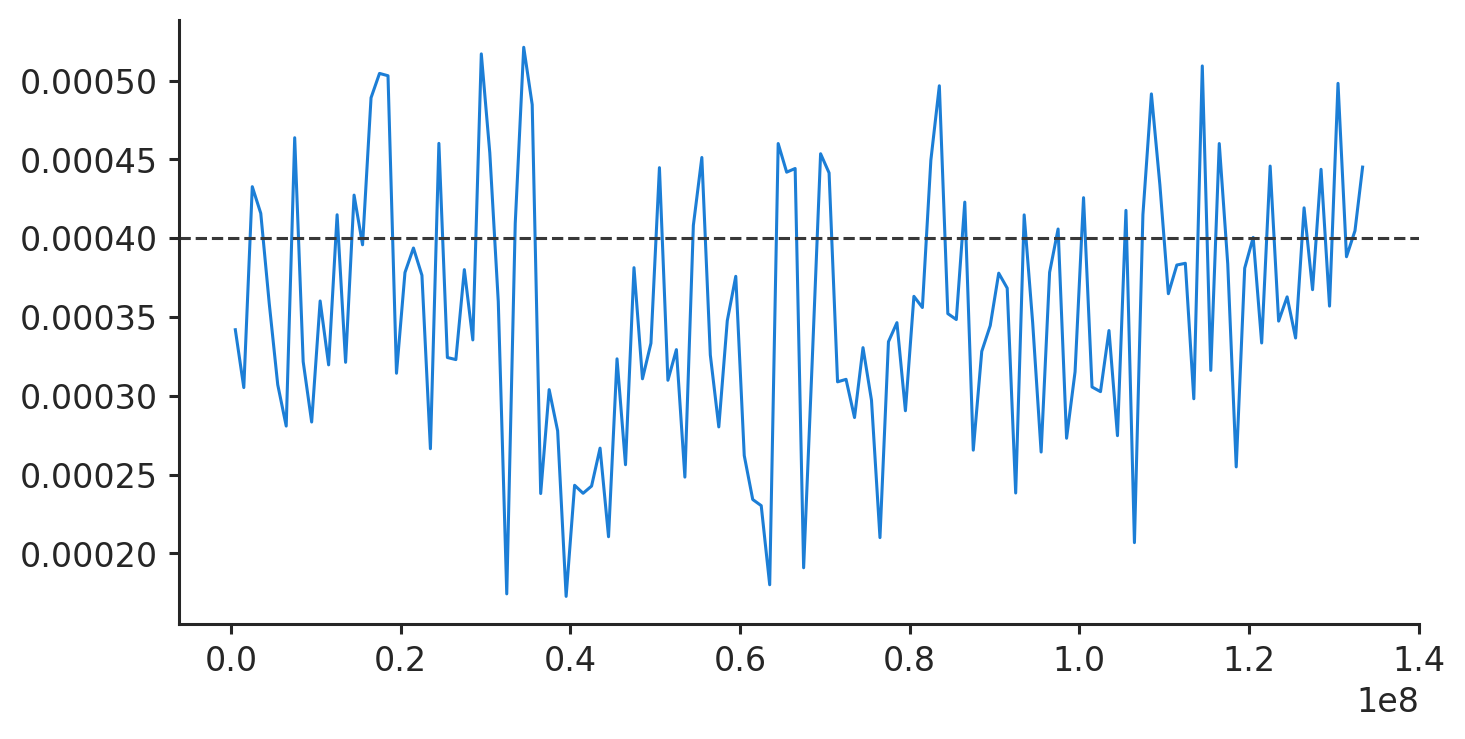

In [84]:
plt.plot(*gd.bin_pi(1e6)[1]['chr10'].pairs) 
N = 1000
mu = 1e-7
plt.axhline(4*N*mu, c='0.22', linestyle='dashed')

In [80]:
from itertools import product

def loglik(pi0, B, Y):
    pibar = pi0 * np.exp(B)
    nS = Y[:, 0][:, None, None, None]
    nD = Y[:, 1][:, None, None, None]
    ll = nD * np.log(pibar) + nS * np.log(1-pibar)
    lls = ll.sum(axis=0)
    nw, nt = B.shape[1], B.shape[2]
    wi, ti = np.arange(nw), np.arange(nt)
    nf = B.shape[3]
    wt = list(product(wi, ti))
    xi = list(product(*[wt for _ in range(nf)]))
    comb_lls = np.zeros(len(xi))
    for i, row in enumerate(xi):
        for j, pair in enumerate(row):
            comb_lls[i] += lls[pair[0], pair[1], j]
    return comb_lls, xi

def loglik_interpol(pi0, B, Y, w):
    pibar = pi0 * np.exp(B)
    nS = Y[:, 0][:, None, None, None]
    nD = Y[:, 1][:, None, None, None]
    ll = nD * np.log(pibar) + nS * np.log(1-pibar)
    lls = ll.sum(axis=0)
    # interpolate the dfe weights for each selcoef
    nf = lls.shape[2]
    nt = B.shape[2]
    interpols = [None] * nf
    for i in range(nf):
        interpols[i] = [None] * nt
        for j in range(nt):
            y = lls[:, j, i]
            assert(len(w) == len(y))
            interpols[i][j] = interpolate.interp1d(w, y, kind='quadratic', bounds_error=False, fill_value=-np.Inf)
            
    def ll_func(x):
        ll = 0
        x = x.reshape(nt, nf)
        for i in range(nf):
            for j in range(nt):
                # TODO fix for multiple features
                ll += interpols[i][j](x[j, i])
        return -ll
    return ll_func



def pred(pi0, B, ml_xi):
    Bc = np.array([B[:, wi, ti, i] for i, (wi, ti) in enumerate(ml_xi)])
    pibar = pi0 * np.exp(Bc.sum(axis=0))
    return pibar

In [ ]:
Y = gd.bin_reduce(1e6)

ERROR! Session/line number was not unique in database. History logging moved to new session 1607


In [93]:
B = m.BScores.B['chr10']

In [94]:
gwpi = gd.gwpi()
pi0s = np.logspace(np.log10(gwpi), -1, 10)
lls = [np.max(loglik(pi0, B, Y)[0]) for pi0 in pi0s]

ValueError: operands could not be broadcast together with shapes (133797423,1,1,1) (13381,6,7,1) 

In [ ]:
plt.plot(pi0s, lls)
plt.semilogx()
plt.scatter(pi0s[np.argmax(lls)], np.max(lls))
plt.axvline(gwpi, c='r')
print(pi0s[np.argmax(lls)])